In [2]:
import pandas as pd
import numpy as np

In [3]:
fear_greed_index = pd.read_csv("fear_greed_index.csv")
historical_data = pd.read_csv("historical_data.csv")

In [4]:
print(fear_greed_index.info())
print(historical_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Account           211224 non-null  object 
 1   Coin              211224 non-null  object 
 2   Execution Price   211224 non-null  float64
 3   Size Tokens       211224 non-null  float64
 4   Size USD          211224 non-null  float64
 5   Side              211224 non-null  object 
 6   Timestamp IST     211224 non-null  object 
 7   Start Position    211224 n

In [ ]:
import pandas as pd

# 1) Parse Fear-Greed date (daily)
fear_greed_index["date"] = pd.to_datetime(
    fear_greed_index["date"], errors="coerce"
).dt.date  # keep only the day

# 2) Parse trades timestamp and extract day
historical_data["Timestamp IST"] = pd.to_datetime(
    historical_data["Timestamp IST"], errors="coerce"
) 
historical_data["date"] = historical_data["Timestamp IST"].dt.date  

# 3) Drop rows where parsing failed (optional but recommended)
fear_greed_index = fear_greed_index.dropna(subset=["date"])
historical_data  = historical_data.dropna(subset=["date"])


In [ ]:
import pandas as pd

# 1) Basic sanity: date ranges
print("FGI range:", fear_greed_index["date"].min(), "to", fear_greed_index["date"].max())
print("Trades range:", historical_data["date"].min(), "to", historical_data["date"].max())

# 2) Missing dates after parsing
print("FGI date missing rate:", fear_greed_index["date"].isna().mean()) 
print("Trades date missing rate:", historical_data["date"].isna().mean())

# 3) Merge on date (attach sentiment to each trade day)
merged = historical_data.merge(
    fear_greed_index[["date", "value", "classification"]],
    on="date",
    how="left"
)

# 4) Verify merge success
print("Share of trades with FGI:", merged["value"].notna().mean())
print("Rows merged:", len(merged))
print("FGI missing after merge (top 5 dates):")
print(merged.loc[merged["value"].isna(), "date"].value_counts().head())


FGI range: 2018-02-01 to 2025-05-02
Trades range: 2023-01-05 to 2025-12-04
FGI date missing rate: 0.0
Trades date missing rate: 0.0
Share of trades with FGI: 0.45268538971284317
Rows merged: 79225
FGI missing after merge (top 5 dates):
date
2025-12-03    3968
2025-09-04    3967
2025-11-03    3286
2025-10-03    2911
2025-07-04    2814
Name: count, dtype: int64


In [7]:
import pandas as pd

cutoff = pd.to_datetime(fear_greed_index["date"]).max()

trades_overlap = historical_data[
    pd.to_datetime(historical_data["date"]) <= cutoff
].copy()

merged_overlap = trades_overlap.merge(
    fear_greed_index[["date", "value", "classification"]],
    on="date",
    how="left"
)

print("Trades kept:", len(merged_overlap), "out of", len(historical_data))
print("Share with FGI:", merged_overlap["value"].notna().mean())
print("Overlap date range:", merged_overlap["date"].min(), "to", merged_overlap["date"].max())


Trades kept: 35864 out of 79225
Share with FGI: 1.0
Overlap date range: 2023-01-05 to 2025-05-02


In [8]:
import numpy as np
import pandas as pd

df = merged_overlap.copy()

df["Closed PnL"] = pd.to_numeric(df["Closed PnL"], errors="coerce")
df["Fee"] = pd.to_numeric(df["Fee"], errors="coerce")
df["Size USD"] = pd.to_numeric(df["Size USD"], errors="coerce")

df["is_win"] = df["Closed PnL"] > 0
df["is_taker"] = df["Crossed"] == True

account_day = (
    df.groupby(["Account", "date"], as_index=False)
      .agg(
          trades=("Order ID", "count"),
          daily_pnl=("Closed PnL", "sum"),
          win_rate=("is_win", "mean"),
          volume_usd=("Size USD", "sum"),
          fees=("Fee", "sum"),
          taker_share=("is_taker", "mean"),
          fgi_value=("value", "first"),
          fgi_classification=("classification", "first"),
      )
)
account_day.head()


,Account,date,trades,daily_pnl,win_rate,volume_usd,fees,taker_share,fgi_value,fgi_classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-06-12,33,-175611.000056,0.000000,1212299.96,121.229992,0.000000,72,Greed
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,177,0.000000,0.000000,900880.13,167.796055,0.090395,76,Extreme Greed
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-01-03,45,9482.221441,0.800000,134360.89,6.718020,0.000000,74,Greed
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-02,10,76710.000000,0.900000,1858470.00,92.923496,0.000000,60,Greed
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-03-02,839,101011.685664,0.305125,19794543.66,2355.038296,0.157330,26,Fear


In [9]:
# 1) Any missing sentiment?
print("Missing fgi_value rate:", account_day["fgi_value"].isna().mean())

# 2) What sentiment regimes exist and how many rows in each?
print(account_day["fgi_classification"].value_counts())

# 3) How many unique accounts + days?
print("unique accounts:", account_day["Account"].nunique())
print("unique days:", account_day["date"].nunique())


Missing fgi_value rate: 0.0
fgi_classification
Greed            191
Fear             157
Extreme Greed    112
Neutral           37
Extreme Fear      33
Name: count, dtype: int64
unique accounts: 32
unique days: 158


In [10]:
prof_by_sent = account_day.groupby("fgi_classification").agg(
    days=("date", "count"),
    accounts=("Account", "nunique"),
    avg_daily_pnl=("daily_pnl", "mean"),
    median_daily_pnl=("daily_pnl", "median"),
    avg_win_rate=("win_rate", "mean"),
).sort_values("days", ascending=False)

prof_by_sent


,days,accounts,avg_daily_pnl,median_daily_pnl,avg_win_rate
fgi_classification,,,,,
Greed,191,29,3191.793365,147.445788,0.353119
Fear,157,28,11332.647023,396.062720,0.349909
Extreme Greed,112,22,10329.407818,108.938997,0.335945
Neutral,37,16,2017.749783,87.752181,0.312524
Extreme Fear,33,20,133.331411,0.000000,0.173498


In [11]:
beh_by_sent = account_day.groupby("fgi_classification").agg(
    avg_trades=("trades", "mean"),
    median_trades=("trades", "median"),
    avg_volume_usd=("volume_usd", "mean"),
    median_volume_usd=("volume_usd", "median"),
    avg_taker_share=("taker_share", "mean"),
    avg_fees=("fees", "mean"),
).sort_values("avg_volume_usd", ascending=False)

beh_by_sent

,avg_trades,median_trades,avg_volume_usd,median_volume_usd,avg_taker_share,avg_fees
fgi_classification,,,,,,
Fear,88.337580,34.0,507480.197834,70653.29,0.638581,99.955796
Neutral,74.486486,33.0,322690.573243,24000.30,0.675093,68.705519
Greed,59.120419,21.0,298669.192356,52243.57,0.718091,64.615492
Extreme Fear,70.484848,20.0,290310.304242,45002.65,0.592165,48.386399
Extreme Greed,50.187500,14.5,162712.145268,74302.17,0.800126,41.946398


In [12]:
import numpy as np
import pandas as pd

ad = account_day.copy()

# 1) Net PnL
ad["net_pnl"] = ad["daily_pnl"] - ad["fees"]

# 2) Winsorize net_pnl at 1% and 99% (simple outlier control)
lo, hi = ad["net_pnl"].quantile([0.01, 0.99])
ad["net_pnl_w"] = ad["net_pnl"].clip(lo, hi)

# Recompute profitability table with net PnL
prof_by_sent_net = ad.groupby("fgi_classification").agg(
    days=("date", "count"),
    accounts=("Account", "nunique"),
    avg_net_pnl=("net_pnl", "mean"),
    median_net_pnl=("net_pnl", "median"),
    avg_net_pnl_w=("net_pnl_w", "mean"),
    median_net_pnl_w=("net_pnl_w", "median"),
    avg_win_rate=("win_rate", "mean"),
).sort_values("days", ascending=False)

prof_by_sent_net


,days,accounts,avg_net_pnl,median_net_pnl,avg_net_pnl_w,median_net_pnl_w,avg_win_rate
fgi_classification,,,,,,,
Greed,191,29,3127.177872,139.544373,4530.323759,139.544373,0.353119
Fear,157,28,11232.691227,364.609954,7960.501198,364.609954,0.349909
Extreme Greed,112,22,10287.461420,91.289831,7108.752103,91.289831,0.335945
Neutral,37,16,1949.044265,24.970582,1949.044265,24.970582,0.312524
Extreme Fear,33,20,84.945012,-0.456405,84.945012,-0.456405,0.173498


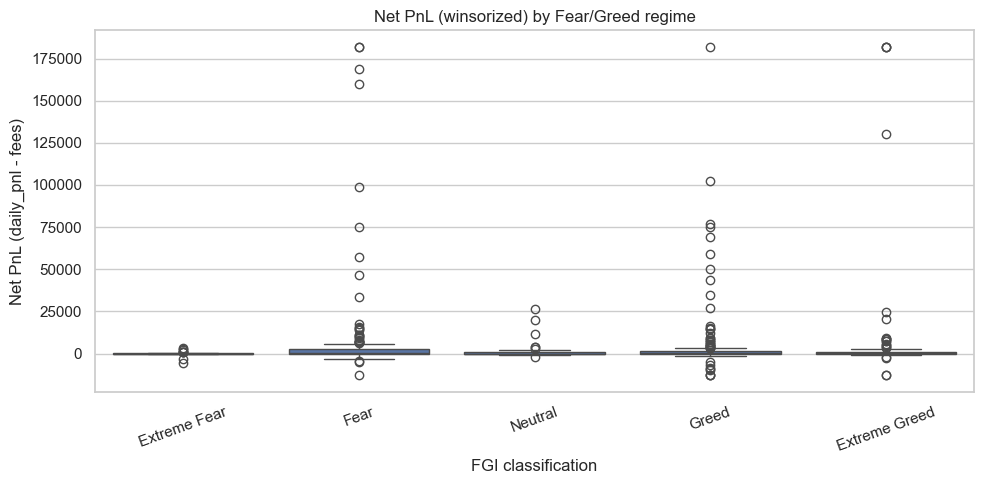

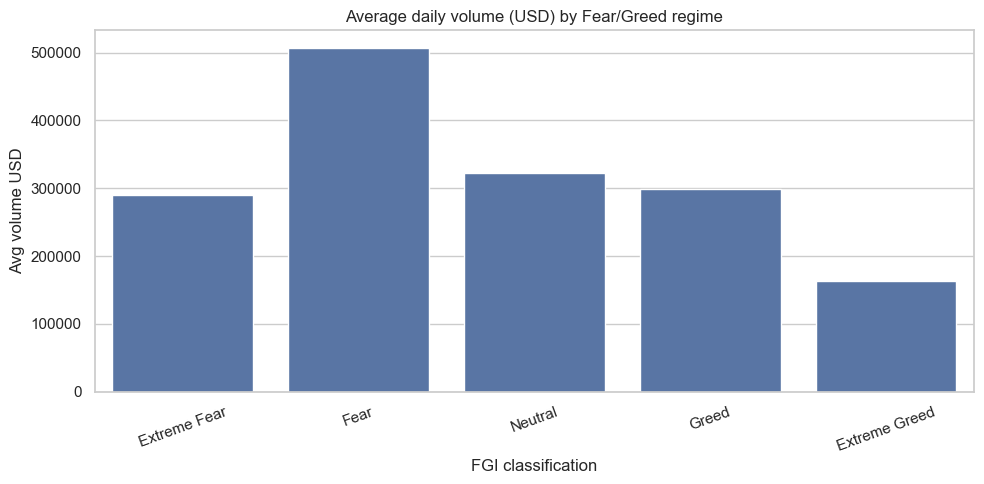

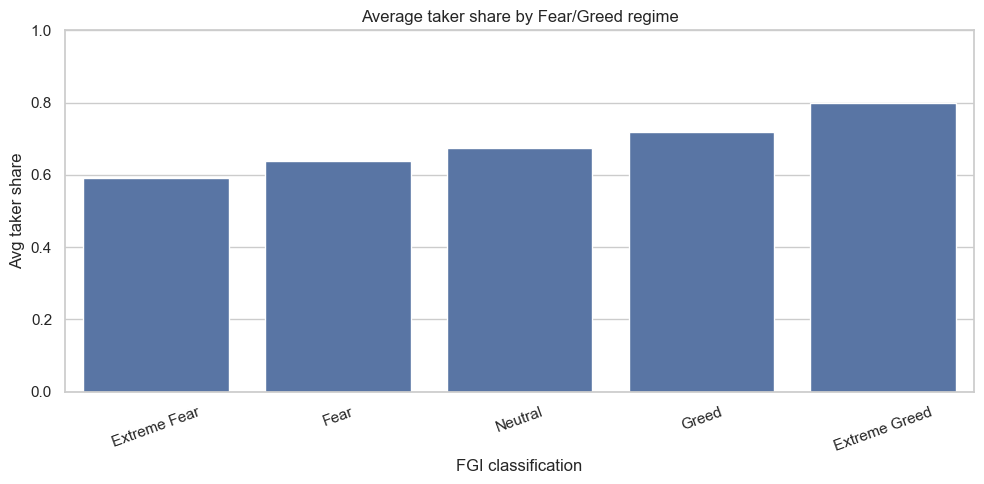

In [13]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- output folder (Colab-friendly) ---
os.makedirs("outputs", exist_ok=True)

# --- work on a copy ---
ad = account_day.copy()

# Ensure correct types
ad["net_pnl"] = ad["daily_pnl"] - ad["fees"]

# Winsorize net PnL (optional but recommended)
lo, hi = ad["net_pnl"].quantile([0.01, 0.99])
ad["net_pnl_w"] = ad["net_pnl"].clip(lo, hi)

# Optional: set a consistent order of sentiment categories for nicer plots
order = ["Extreme Fear", "Fear", "Neutral", "Greed", "Extreme Greed"]

sns.set_theme(style="whitegrid")

# 1) Boxplot: net_pnl_w by fgi_classification
plt.figure(figsize=(10, 5))
ax = sns.boxplot(
    data=ad,
    x="fgi_classification",
    y="net_pnl_w",
    order=[c for c in order if c in ad["fgi_classification"].unique()],
)
ax.set_title("Net PnL (winsorized) by Fear/Greed regime")
ax.set_xlabel("FGI classification")
ax.set_ylabel("Net PnL (daily_pnl - fees)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig("outputs/boxplot_net_pnl_w_by_fgi.png", dpi=200, bbox_inches="tight")  # savefig via matplotlib [web:133]
plt.show()

# 2) Bar chart: avg_volume_usd by fgi_classification
vol = (ad.groupby("fgi_classification", as_index=False)
         .agg(avg_volume_usd=("volume_usd", "mean")))
vol["fgi_classification"] = pd.Categorical(vol["fgi_classification"], categories=order, ordered=True)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=vol.sort_values("fgi_classification"), x="fgi_classification", y="avg_volume_usd")
ax.set_title("Average daily volume (USD) by Fear/Greed regime")
ax.set_xlabel("FGI classification")
ax.set_ylabel("Avg volume USD")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig("outputs/bar_avg_volume_usd_by_fgi.png", dpi=200, bbox_inches="tight")
plt.show()

# 3) Bar chart: avg_taker_share by fgi_classification
ts = (ad.groupby("fgi_classification", as_index=False)
        .agg(avg_taker_share=("taker_share", "mean")))
ts["fgi_classification"] = pd.Categorical(ts["fgi_classification"], categories=order, ordered=True)

plt.figure(figsize=(10, 5))
ax = sns.barplot(data=ts.sort_values("fgi_classification"), x="fgi_classification", y="avg_taker_share")
ax.set_title("Average taker share by Fear/Greed regime")
ax.set_xlabel("FGI classification")
ax.set_ylabel("Avg taker share")
plt.ylim(0, 1)
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig("outputs/bar_avg_taker_share_by_fgi.png", dpi=200, bbox_inches="tight")
plt.show()


In [14]:
import numpy as np
import pandas as pd

ad = account_day.copy()
ad["date"] = pd.to_datetime(ad["date"])

# Profit after costs (already consistent with your notebook)
ad["net_pnl"] = ad["daily_pnl"] - ad["fees"]

# ---- Leverage proxy (since leverage column is not present) ----
# Use average notional per trade as "risk-taking intensity" proxy
ad["avg_notional_per_trade"] = ad["volume_usd"] / ad["trades"].replace(0, np.nan)

# ---- Risk flags ----
ad["is_loss_day"] = ad["net_pnl"] < 0

# Sort for time-series calculations
ad = ad.sort_values(["Account", "date"])

# ---- Equity curve per account (in USD PnL units) ----
ad["cum_net_pnl"] = ad.groupby("Account")["net_pnl"].cumsum()  # cumulative sum by group [web:163]

# Running peak of equity curve per account
ad["cum_peak"] = ad.groupby("Account")["cum_net_pnl"].cummax()  # cumulative max by group [web:154]

# Drawdown in PnL-units (<= 0); max drawdown is the minimum of this series
ad["drawdown"] = ad["cum_net_pnl"] - ad["cum_peak"]

In [ ]:
account_risk = (
    ad.groupby("Account", as_index=False)
      .agg(
          days=("date", "count"),
          pnl_mean=("net_pnl", "mean"),
          pnl_std=("net_pnl", "std"),                # volatility proxy
          loss_rate=("is_loss_day", "mean"),         # downside frequency
          max_drawdown=("drawdown", "min"),          # most negative drawdown (PnL units)
          avg_notional_per_trade=("avg_notional_per_trade", "mean"),  # leverage proxy
          avg_volume_usd=("volume_usd", "mean"),
          avg_taker_share=("taker_share", "mean"),
      )
)

account_risk.head()


,Account,days,pnl_mean,pnl_std,loss_rate,max_drawdown,avg_notional_per_trade,avg_volume_usd,avg_taker_share
0,0x083384f897ee0f19899168e3b1bec365f52a9012,8,120146.555571,226276.597485,0.250000,-167.796055,37473.098090,5.058192e+06,0.079156
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,11,1222.980020,2352.264878,0.363636,-3190.489246,6330.878397,2.188166e+05,0.754421
2,0x271b280974205ca63b716753467d5a371de622ab,1,174.687749,NaN,0.000000,0.000000,39530.987500,1.581240e+05,0.750000
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,31,1878.232378,3368.388223,0.064516,-1452.233682,451.851123,3.289936e+04,0.932519
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,15,2845.855402,4871.233340,0.266667,-855.477772,2475.001375,7.344932e+04,0.876797


In [ ]:
risk_by_sent = (
    ad.groupby("fgi_classification", as_index=False)
      .agg(
          days=("date", "count"),
          avg_net_pnl=("net_pnl", "mean"),
          net_pnl_std=("net_pnl", "std"),          # regime-level volatility proxy
          loss_rate=("is_loss_day", "mean"),
          avg_drawdown=("drawdown", "mean"),
          worst_drawdown=("drawdown", "min"),
          avg_volume_usd=("volume_usd", "mean"),
          avg_notional_per_trade=("avg_notional_per_trade", "mean"),
          avg_taker_share=("taker_share", "mean"),
      )
      .sort_values("days", ascending=False)
)

risk_by_sent


,fgi_classification,days,avg_net_pnl,net_pnl_std,loss_rate,avg_drawdown,worst_drawdown,avg_volume_usd,avg_notional_per_trade,avg_taker_share
3,Greed,191,3127.177872,24732.996650,0.361257,-8825.028487,-123960.815305,298669.192356,7029.606816,0.718091
2,Fear,157,11232.691227,55821.024970,0.350318,-11376.023628,-126618.875285,507480.197834,7518.449558,0.638581
1,Extreme Greed,112,10287.461420,57883.786935,0.383929,-8442.752669,-109074.044092,162712.145268,7027.976333,0.800126
4,Neutral,37,1949.044265,5606.084948,0.405405,-9143.024868,-101162.387682,322690.573243,5763.624619,0.675093
0,Extreme Fear,33,84.945012,1503.662932,0.575758,-10616.513288,-123972.007144,290310.304242,7641.104727,0.592165


In [ ]:
from scipy.stats import ttest_ind

a = ad.loc[ad["fgi_classification"]=="Extreme Fear", "net_pnl"].dropna()
b = ad.loc[ad["fgi_classification"]=="Greed", "net_pnl"].dropna()

t_stat, p_val = ttest_ind(a, b, equal_var=False)  # Welch t-test 
print("t =", t_stat, "p =", p_val)


t = -1.6820387985082377 p = 0.09414028778410312


In [18]:
import numpy as np

def cohens_d(x, y):
    x, y = np.asarray(x), np.asarray(y)
    nx, ny = len(x), len(y)
    sx, sy = x.std(ddof=1), y.std(ddof=1)
    s_pooled = np.sqrt(((nx-1)*sx**2 + (ny-1)*sy**2) / (nx+ny-2))
    return (x.mean() - y.mean()) / s_pooled

print("Cohen's d =", cohens_d(a, b))


Cohen's d = -0.1329169195353699


In [ ]:
import os
from pathlib import Path

# --- Output folders ---
BASE_DIR = Path(".")
CSV_DIR = BASE_DIR / "csv_files"
FIG_DIR = BASE_DIR / "figures"
TXT_DIR = BASE_DIR / "results_txt"

# Create directories if they don't exist
CSV_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
TXT_DIR.mkdir(parents=True, exist_ok=True)  # optional for logs/text results
# (Same idea as os.makedirs(..., exist_ok=True)) 


In [20]:
def save_csv(df, name: str, index=False):
    out = CSV_DIR / f"{name}.csv"
    df.to_csv(out, index=index)
    return out

In [22]:
save_csv(prof_by_sent, "prof_by_sent", index=True)
save_csv(beh_by_sent, "beh_by_sent", index=True)
save_csv(risk_by_sent, "risk_by_sent", index=True)
save_csv(account_risk, "account_risk", index=False)

WindowsPath('csv_files/account_risk.csv')

In [ ]:
from pathlib import Path
from datetime import datetime

# assumes BASE_DIR, CSV_DIR, FIG_DIR, TXT_DIR already exist (from previous cell)

def write_readme():
    readme_path = BASE_DIR / "README.md"

    content = f"""# Fear–Greed Regime Assessment (Notebook Outputs)

Generated on: {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}

## Project structure
- `{CSV_DIR.as_posix()}/` : All exported tables/metrics as CSV
- `{FIG_DIR.as_posix()}/` : Saved figures (plots)
- `{TXT_DIR.as_posix()}/` : Optional text logs / test summaries

## Key CSV files (expected)
- `prof_by_sent.csv` : profitability summary by FGI regime
- `beh_by_sent.csv` : behavior summary by FGI regime
- `risk_by_sent.csv` : risk summary by FGI regime
- `account_risk.csv` : per-account risk summary
- `welch_test_extreme_fear_vs_greed_net_pnl.csv` : Welch t-test + Cohen’s d summary (example)

## Notes
- `net_pnl = dailypnl - fees`
- `loss_rate = mean(net_pnl < 0)`
- Drawdown is computed per account from the cumulative net PnL curve.

## How to regenerate
1. Run the notebook top-to-bottom.
2. All CSVs will be written to `{CSV_DIR.as_posix()}` and figures to `{FIG_DIR.as_posix()}`.
"""

    readme_path.write_text(content, encoding="utf-8")  # overwrites if exists [web:202]
    return readme_path

write_readme()


WindowsPath('README.md')